SEL feature importance

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import logging
import pickle
from sellibrary.text_file_loader import load_feature_matrix
from sellibrary.filter_only_golden import FilterGolden


from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.learning_curve import learning_curve 
from sklearn.cross_validation import ShuffleSplit, train_test_split 
from sklearn.grid_search import GridSearchCV

from sellibrary.gbrt import GBRTWrapper
from sellibrary.util.test_train_splitter import DataSplitter


In [2]:
from sellibrary.locations import FileLocations
INTERMEDIATE_PATH = FileLocations.get_dropbox_intermediate_path()



In [14]:



handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s'))
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.propagate = False
logger.setLevel(logging.INFO)



In [36]:
light_feature_names = [
    'min_normalised_position',  # 1
    'max_normalised_position',  # 1
    'mean_normalised_position',  # 1
    'normalised_position_std_dev',  # 1
    'norm_first_position_within_first 3 sentences',  # 2
    'norm first positon within body middle',  # 2
    'norm_first_position_within last 3 sentences',  # 2
    'normed first position within title',  # 2
    'averaged normed position within sentences',  # 3
    'freq in first 3 sentences of body ',  # 4
    'freq in middle of body ',  # 4
    'freq in last 3 sentences of body ',  # 4
    'freq in title ',  # 4
    'one occurrence capitalised',  # 5
    'maximum fraction of uppercase letters',  # 6
    'average spot length in words',  # 8.1 :
    'average spot length in characters',  # 8.2 :
    'is in title',  # 11 :
    'unambiguous entity frequency',  # 14 : 1 entity frequency feature
    'entity in_degree in wikipeada',  # 20 :
    'entity out_degree in wikipeada',  # 20 :
    'entity degree in wikipeada',  # 20 :
    'document length',  # 22 :
]

heavy_feature_names = [
    'v1_graph_size', 'v1_graph_diameter', 'v1_node_degree', 'v1_degree_mean_median_ratio',
    'v1_out_degree_mean_median_ratio', 'v1_degree_mean_median_ratio', 'v1_farness', 'v1_closeness', 'v1_centrality',
    'v1_minus_low_relatedness_graph_size', 'v1_minus_low_relatedness_graph_diameter',
    'v1_minus_low_relatedness_node_degree', 'v1_minus_low_relatedness_degree_mean_median_ratio',
    'v1_minus_low_relatedness_out_degree_mean_median_ratio', 'v1_minus_low_relatedness_degree_mean_median_ratio',
    'v1_minus_low_relatedness_farness', 'v1_minus_low_relatedness_closeness',
    'v1_minus_low_relatedness_centrality', 'v0_graph_size', 'v0_graph_diameter', 'v0_node_degree',
    'v0_degree_mean_median_ratio', 'v0_out_degree_mean_median_ratio', 'v0_degree_mean_median_ratio', 'v0_farness',
    'v0_closeness', 'v0_centrality', 'v0_minus_low_relatedness_graph_size',
    'v0_minus_low_relatedness_graph_diameter', 'v0_minus_low_relatedness_node_degree',
    'v0_minus_low_relatedness_degree_mean_median_ratio', 'v0_minus_low_relatedness_out_degree_mean_median_ratio',
    'v0_minus_low_relatedness_degree_mean_median_ratio', 'v0_minus_low_relatedness_farness',
    'v0_minus_low_relatedness_closeness', 'v0_minus_low_relatedness_centrality'
]

all_feature_names = light_feature_names
all_feature_names.extend(heavy_feature_names)

X_sel, y_sel, docid_array_sel, entity_id_array_sel = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+'aws/all.txt',
    feature_names=all_feature_names,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=len(all_feature_names)+4,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )

2018-07-23 10:18:37,400 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/aws/all.txt
2018-07-23 10:18:38,531 sellibrary.text_file_loader INFO     10000 lines processed
2018-07-23 10:18:38,585 sellibrary.text_file_loader INFO     20000 lines processed
2018-07-23 10:18:38,639 sellibrary.text_file_loader INFO     30000 lines processed
2018-07-23 10:18:38,696 sellibrary.text_file_loader INFO     40000 lines processed
2018-07-23 10:18:38,746 sellibrary.text_file_loader INFO     50000 lines processed
2018-07-23 10:18:38,802 sellibrary.text_file_loader INFO     60000 lines processed
2018-07-23 10:18:38,805 sellibrary.text_file_loader INFO     skipping line with 125 rather than 63 fields "26,716712,0,0,[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 741, 2.0, 2, 0, 1.0539811066126856, 2.1079622132253713, 2.0, 0.5, 1, 633, 2.0, 2, 0, 1.0442338072669826, 2.088467614533965, 2.0, 0.5, 1, 0, 0, 0, nan, nan, nan, 0, 0, 0, 0, 0

In [ ]:
# Filter out non golden 

In [37]:

# train only on records we have a golden salience for
fg = FilterGolden()
X2_sel, y2_sel, docid2_sel, entityid2_sel = fg.get_only_golden_rows(
    X_sel, y_sel, docid_array_sel, entity_id_array_sel)


In [133]:
print(X2_sel.shape)

(3808, 59)


In [134]:
# Grid Search Meta Parameters

In [156]:
def get_num_jobs():
    if sys.platform == 'win32':
        return 8
    else:
        if sys.platform == 'linux': # Sherlock ML
            return 8
        else:
            return 2 # mac

def MyGridSearchCV(param_grid, n_jobs, X, y, estimator):
    
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
    #different train/cv splits using parameters specified and return the model that has the best results 

    # 
    #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be 
    #the best score to tune our model on.  For now, we'll use F1.
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    #Also note that we're feeding multiple neighbors to the GridSearch to try out. 
    #We'll now fit the training dataset to this classifier
    classifier.fit(X, y)
    #Let's look at the best estimator that was found by GridSearchCV
    print ("Best Estimator learned through GridSearch")
    print ( classifier.best_estimator_)
    return cv, classifier.best_estimator_, classifier
    


def print_info(best_est, X, y, tset):
    print ("--------------------------------" )
    print (tset+" Best Estimator Parameters" )
    print ("--------------------------------" )
    print ("n_estimators: %d" %best_est.n_estimators )
#     print ("max_depth: %d" %best_est.max_depth )
#     print ("min_samples_leaf: %d" %best_est.min_samples_leaf )
#     print ("max_features: %.2f" %best_est.max_features )
    print (tset+" R-squared: %.2f" %best_est.score(X,y) )     
#     print ("Learning Rate: %.2f" %best_est.learning_rate )

    
def perform_grid_search(X,y):

    # if no space left on device, try setting the env ver JOBLIB_TEMP_FOLDER to /tmp
    %env JOBLIB_TEMP_FOLDER=/tmp
    #WARNING - THIS MIGHT TAKE A WHILE TO RUN. 
    # TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
    #increasing this make sure your system can handle it), n_iter for ShuffleSplit 
    # (in the function definition) and reducing #number of values being tried for max_depth/n_estimators. 
    #SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION 
    logger.info('starting')

    param_grid={'n_estimators':[5, 6] # 
#                 'max_features':[1,5,10,20],  #
#                 'max_depth':[4,8,16,32]      #
               } 
    n_jobs = get_num_jobs() 

    #Let's fit GBRT to the digits training dataset by calling the function we just created. 
    estimator = ExtraTreesRegressor()

    cv, best_est, trained_model=MyGridSearchCV(param_grid, n_jobs, X, y, estimator) 
    logger.info('complete')
    print_info(best_est, X, y, '.8CV')
    
    return cv, best_est


  

In [157]:
cv, best_est = perform_grid_search(X_sel,y_sel)

2018-07-23 16:12:24,693 __main__     INFO     starting


env: JOBLIB_TEMP_FOLDER=/tmp


2018-07-23 16:17:18,126 __main__     INFO     complete


Best Estimator learned through GridSearch
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
--------------------------------
.8CV Best Estimator Parameters
--------------------------------
n_estimators: 6
.8CV R-squared: 0.99


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

(3808, 59)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


oob score :-0.202797710758
Feature ranking:
1, feature, 0, min_normalised_position, 0.265319 
2, feature, 12, freq in title , 0.156170 
3, feature, 4, norm_first_position_within_first 3 sentences, 0.049790 
4, feature, 2, mean_normalised_position, 0.045227 
5, feature, 15, average spot length in words, 0.024435 
6, feature, 9, freq in first 3 sentences of body , 0.021763 
7, feature, 22, document length, 0.020917 
8, feature, 8, averaged normed position within sentences, 0.020845 
9, feature, 20, entity out_degree in wikipeada, 0.020587 
10, feature, 16, average spot length in characters, 0.020505 
11, feature, 14, maximum fraction of uppercase letters, 0.018767 
12, feature, 28, v1_degree_mean_median_ratio, 0.017487 
13, feature, 1, max_normalised_position, 0.017267 
14, feature, 3, normalised_position_std_dev, 0.016479 
15, feature, 18, unambiguous entity frequency, 0.015165 
16, feature, 30, v1_closeness, 0.014349 
17, feature, 5, norm first positon within body middle, 0.013662 
18,

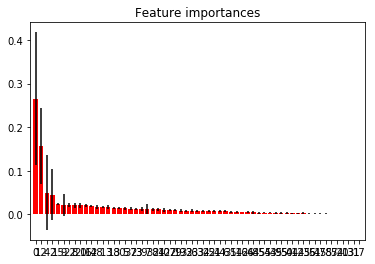

In [159]:
# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=best_est.n_estimators,
                              random_state=0,
                            oob_score=True, verbose=True, bootstrap = True)

forest.fit(X2_sel, y2_sel)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("oob score :"+str(forest.oob_score_))

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_sel.shape[1]):
    print("%d, feature, %d, %s, %f " % (f + 1, indices[f], light_feature_names[indices[f]], importances[indices[f]] ))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2_sel.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2_sel.shape[1]), indices)
plt.xlim([-1, X2_sel.shape[1]])
plt.show()
GRAPH_PATH = '/Users/dsluis/Dropbox/UCL/UCL - Business Analytics specialisation in Computer Science/T3-COMPG099 - Dissertation/Diagrams/'
plt.savefig(GRAPH_PATH+'feature_importance_RF.png')


# Split Data - to train real model

In [167]:
splitter = DataSplitter()
X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X2_sel,y2_sel,
                                                                                        docid2_sel,7,train_split=0.50)


print(X_train.shape)
print(X_test.shape)

(1972, 59)
(1836, 59)


In [ ]:
# Train forest on training data

In [168]:
# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=best_est.n_estimators,
                              random_state=0,
                            oob_score=True, verbose=True, bootstrap = True)

forest.fit(X2_sel, y2_sel)

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
          oob_score=True, random_state=0, verbose=True, warm_start=False)

# Save RF SEL Model

In [169]:
output_filename = INTERMEDIATE_PATH+'sel_golden_spotter_RF.pickle'
with open(output_filename, 'wb') as handle:
     pickle.dump(forest, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [170]:
sent_feature_names = [
    'title_sentiment_ngram_20', 
    'title_neg_sent_ngram_20',
    'title_pos_sent_ngram_20',   
    'body_sentiment_ngram_20', 
    'body_neg_sent_ngram_20',
    'body_pos_sent_ngram_20'
]    


X_sent, y_sent, docid_array_sent, entity_id_array_sent = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+'sentiment_simple.txt',
    feature_names=sent_feature_names,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=10,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )

2018-07-23 17:25:50,273 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/sentiment_simple.txt
2018-07-23 17:25:50,345 sellibrary.text_file_loader INFO     4715 lines loaded from /Users/dsluis/Dropbox/Datasets/intermediate/sentiment_simple.txt


In [174]:
splitter = DataSplitter()
X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X_sent,y_sent,
                                                                                        docid_array_sent,7,train_split=0.50)


print(X_train.shape)
print(X_test.shape)

(2414, 6)
(2301, 6)


In [175]:

# # train only on records we have a golden salience for
# fg = FilterGolden()
# X2_sent, y2_sent, docid2_sent, entityid2_sent = fg.get_only_golden_rows(X_sent, y_sent, docid_array_sent, entity_id_array_sent)


# print(X2_sent.shape)

In [176]:
in_train_set_by_id

ids_in_trainset = []
ids_in_testset = []
for i in in_train_set_by_id.keys():
    if in_train_set_by_id[i]:
        ids_in_trainset.append(int(i))
    else:
        ids_in_testset.append(int(i))
        
len(ids_in_trainset)
s = str(ids_in_trainset)
s = s.replace(' ','').replace('[','').replace(']','')
print('Trainset\n'+s)
print('Length:'+str(len(ids_in_trainset)))


len(ids_in_testset)
s = str(ids_in_testset)
s = s.replace(' ','').replace('[','').replace(']','')
print('Testset\n'+s)
print('Length:'+str(len(ids_in_testset)))




Trainset
1,2,4,6,7,9,10,11,12,13,16,17,22,24,26,27,28,29,31,34,36,37,38,40,41,43,44,49,54,56,57,60,62,63,71,75,78,81,86,87,89,90,91,93,94,96,98,99,101,103,108,109,110,113,114,115,116,118,123,124,125,126,136,141,144,145,148,149,150,151,153,154,155,156,157,158,159,162,163,165,166,167,170,171,172,173,174,175,178,179,182,184,189,190,191,195,196,204,206,207,208,209,210,213,217,218,219,221,222,226,229,235,236,238,241,242,245,246,247,250,254,256,257,262,265,266,267,268,270,271,272,274,275,278,283,284,285,288,290,291,294,299,301,302,308,315,317,323,327,329,330,331,332,333,338,341,530,532,534,540,541,543,544,545,548,551,552,553,561,568,569,570,572,573,574,577,578,582,583,587,588,592,594,596,597,600,601,603,604
Length:189
Testset
3,5,8,14,18,20,21,23,25,30,32,33,35,39,42,45,46,50,51,52,53,55,58,64,66,68,70,72,73,74,76,77,80,82,83,84,85,88,95,100,104,105,106,107,111,112,119,127,129,131,132,133,134,137,138,139,140,146,160,161,168,169,177,180,181,183,185,186,187,188,192,193,194,197,198,199,200,202,

In [177]:


# Build a forest and compute the feature importances
sent_forest = ExtraTreesRegressor(n_estimators=6,
                              random_state=0,
                            oob_score=True, verbose=True, bootstrap = True)

sent_forest.fit(X_train, y_train)
importances = sent_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in sent_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_sent.shape[1]):
    print("%d. feature %d (%f) %s " % (f + 1, indices[f], importances[indices[f]],  sent_feature_names[indices[f]] ))



Feature ranking:
1. feature 3 (0.266229) body_sentiment_ngram_20 
2. feature 4 (0.202660) body_neg_sent_ngram_20 
3. feature 5 (0.192604) body_pos_sent_ngram_20 
4. feature 2 (0.144034) title_pos_sent_ngram_20 
5. feature 1 (0.098946) title_neg_sent_ngram_20 
6. feature 0 (0.095526) title_sentiment_ngram_20 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


# Save Sent RF Model

In [179]:
output_filename = INTERMEDIATE_PATH+'sent_golden_spotter_RF.pickle'
with open(output_filename, 'wb') as handle:
     pickle.dump(sent_forest, handle, protocol=pickle.HIGHEST_PROTOCOL)




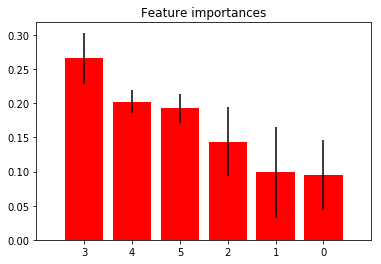

In [178]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2_sent.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2_sent.shape[1]), indices)
plt.xlim([-1, X2_sent.shape[1]])
plt.savefig(GRAPH_PATH+'Simple Sentiment Feature Importance RF.png')
plt.show()



In [77]:
print (X2_sent.shape)

(4715, 6)


In [123]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2





y3_sent = y2_sent
y3_sent[y3_sent<2.0] = 0
y3_sent[y3_sent>=2.0] = 1
y3_sent


np.min(X3_sent[:,3])

X3_sent[:,0] = (X3_sent[:,0]/10) + 0.5
X3_sent[:,3] = (X3_sent[:,3]/10) + 0.5
X3_sent[:,3] = X3_sent[:,3] + 0.1


list_of_important_features = []

for i in range(X3_sent.shape[1]):
    chi2_selector = SelectKBest(chi2, k=i+1)
    X_kbest = chi2_selector.fit_transform(X3_sent, y3_sent)
    print(chi2_selector.get_support(True))
    
    for f in chi2_selector.get_support(True):
        if f not in list_of_important_features:
            print('adding '+str(f))
            list_of_important_features.append(f)
            
    
print(list_of_important_features)

[5]
adding 5
[4 5]
adding 4
[2 4 5]
adding 2
[1 2 4 5]
adding 1
[0 1 2 4 5]
adding 0
[0 1 2 3 4 5]
adding 3
[5, 4, 2, 1, 0, 3]


In [111]:

chi2_selector.get_support(True)




array([3, 4, 5])

{'k': 3,
 'score_func': <function sklearn.feature_selection.univariate_selection.chi2>}

# Join Sent and SEL together into large matrix

In [180]:

from sellibrary.util.const import Const



['min_normalised_position',
 'max_normalised_position',
 'mean_normalised_position',
 'normalised_position_std_dev',
 'norm_first_position_within_first 3 sentences',
 'norm first positon within body middle',
 'norm_first_position_within last 3 sentences',
 'normed first position within title',
 'averaged normed position within sentences',
 'freq in first 3 sentences of body ',
 'freq in middle of body ',
 'freq in last 3 sentences of body ',
 'freq in title ',
 'one occurrence capitalised',
 'maximum fraction of uppercase letters',
 'average spot length in words',
 'average spot length in characters',
 'is in title',
 'unambiguous entity frequency',
 'entity in_degree in wikipeada',
 'entity out_degree in wikipeada',
 'entity degree in wikipeada',
 'document length',
 'v1_graph_size',
 'v1_graph_diameter',
 'v1_node_degree',
 'v1_degree_mean_median_ratio',
 'v1_out_degree_mean_median_ratio',
 'v1_degree_mean_median_ratio',
 'v1_farness',
 'v1_closeness',
 'v1_centrality',
 'v1_minus_lo

In [181]:
 


X_joined, y_joined, docid_array_joined, entity_id_array_joined = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+'joined.txt',
    feature_names=Const.joined_feature_names,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=len(Const.joined_feature_names)+4,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )

2018-07-25 11:15:35,109 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/joined.txt
2018-07-25 11:15:35,335 sellibrary.text_file_loader INFO     3763 lines loaded from /Users/dsluis/Dropbox/Datasets/intermediate/joined.txt


In [182]:
splitter = DataSplitter()
X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X_joined,y_joined,
                                                                                        docid_array_joined,7,train_split=0.50)




In [185]:
joined_model = ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
          oob_score=True, random_state=None, verbose=0, warm_start=False)


joined_model.fit(X_train, y_train)
importances = joined_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f) %s " % (f + 1, indices[f], importances[indices[f]],  Const.joined_feature_names[indices[f]] ))




Feature ranking:
1. feature 12 (0.260908) freq in title  
2. feature 0 (0.122251) min_normalised_position 
3. feature 4 (0.085305) norm_first_position_within_first 3 sentences 
4. feature 9 (0.034096) freq in first 3 sentences of body  
5. feature 2 (0.033549) mean_normalised_position 
6. feature 16 (0.021240) average spot length in characters 
7. feature 8 (0.020618) averaged normed position within sentences 
8. feature 22 (0.019612) document length 
9. feature 14 (0.017490) maximum fraction of uppercase letters 
10. feature 5 (0.016533) norm first positon within body middle 
11. feature 28 (0.015937) v1_degree_mean_median_ratio 
12. feature 20 (0.015434) entity out_degree in wikipeada 
13. feature 15 (0.015264) average spot length in words 
14. feature 37 (0.014859) v1_minus_low_relatedness_degree_mean_median_ratio 
15. feature 39 (0.014067) v1_minus_low_relatedness_closeness 
16. feature 63 (0.013731) body_neg_sent_ngram_20 
17. feature 23 (0.013593) v1_graph_size 
18. feature 1 (0.

/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [186]:
output_filename = INTERMEDIATE_PATH+'joined_RF.pickle'
with open(output_filename, 'wb') as handle:
     pickle.dump(joined_model, handle, protocol=pickle.HIGHEST_PROTOCOL)


